In [79]:
using Pkg
Pkg.add(["CSV", "DataFrames", "StatsPlots", "Statistics", "MLJ"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [80]:
using CSV, DataFrames, StatsPlots, Statistics, MLJ

## Read data

In [7]:
data = CSV.File("data/train.csv") |> DataFrame;

## Study data format and distribution

In [33]:
print(data[1:3, :])

3×12 DataFrame
 Row │ PassengerId  Survived  Pclass  Name                               Sex     Age       SibSp  Parch  Ticket            Fare     Cabin    Embarked 
     │ Int64        Int64     Int64   String                             String  Float64?  Int64  Int64  String            Float64  String?  String?  
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │           1         0       3  Braund, Mr. Owen Harris            male        22.0      1      0  A/5 21171          7.25    missing  S
   2 │           2         1       1  Cumings, Mrs. John Bradley (Flor…  female      38.0      1      0  PC 17599          71.2833  C85      C
   3 │           3         1       3  Heikkinen, Miss. Laina             female      26.0      0      0  STON/O2. 3101282   7.925   missing  S

In [9]:
describe(data)

,variable,mean,min,median,max
,Symbol,Union…,Any,Union…,Any
1,PassengerId,446.0,1,446.0,891
2,Survived,0.383838,0,0.0,1
3,Pclass,2.30864,1,3.0,3
4,Name,,"Abbing, Mr. Anthony",,"van Melkebeke, Mr. Philemon"
5,Sex,,female,,male
6,Age,29.6991,0.42,28.0,80.0
7,SibSp,0.523008,0,0.0,8
8,Parch,0.381594,0,0.0,6
9,Ticket,,110152,,WE/P 5735


In [17]:
schema(data)

┌─────────────┬─────────────────────────┬────────────────────────────┐
│ _.names     │ _.types                 │ _.scitypes                 │
├─────────────┼─────────────────────────┼────────────────────────────┤
│ PassengerId │ Int64                   │ Count                      │
│ Survived    │ Int64                   │ Count                      │
│ Pclass      │ Int64                   │ Count                      │
│ Name        │ String                  │ Textual                    │
│ Sex         │ String                  │ Textual                    │
│ Age         │ Union{Missing, Float64} │ Union{Missing, Continuous} │
│ SibSp       │ Int64                   │ Count                      │
│ Parch       │ Int64                   │ Count                      │
│ Ticket      │ String                  │ Textual                    │
│ Fare        │ Float64                 │ Continuous                 │
│ Cabin       │ Union{Missing, String}  │ Union{Missing, Textual}    │
│ Emba

## Study of missing values
As we can see from the above table, our data has missing values for the "Age", "Cabin", and "Embarked" fields.

We must assess the proportion of the missing data in the train set to help us decide how to deal with them.

In [30]:
nmissing_age = 0
missing_age_index = []
# iterate through each row
for index in 1:size(data)[1]
    # check if age is missing
    if ismissing(data[index, :Age])
        nmissing_age += 1
        push!(missing_age_index, index)
    end
end
print(nmissing_age)

177

In [35]:
nsurvived_missing_age = 0
for value in eachrow(data[missing_age_index, :])
    if value.Survived == 1
        nsurvived_missing_age += 1
    end
end
print(nsurvived_missing_age)

52

### A large part of the data has missing values for Age, this can turn out to be problematic for the ML algorithms...
A possible solution would be to drop the "Age" column if there is not a big correlation with target labels.

Another would be to replace missing values with random integers sampled according to the mean and variance of the available data.

In [36]:
nmissing_cabin = 0
for index in 1:size(data)[1]
    # check if cabin is missing
    if ismissing(data[index, :Cabin])
        nmissing_cabin += 1
    end
end
print(nmissing_cabin)

687

### The majority of our data does not have a value for the "Cabin" field.
This doesn't leave much to choose from..

Again, we can simply drop the field.

Or map it to a new "HasCabin" property.

In [37]:
data[:, [:Cabin, :Pclass]]

,Cabin,Pclass
,String?,Int64
1,missing,3
2,C85,1
3,missing,3
4,C123,1
5,missing,3
6,missing,3
7,E46,1
8,missing,3
9,missing,3


### We can notice that it is more common for people in second or third class to have a missing cabin.
Let's study the relation between these two properties

In [59]:
m = zeros(Int64, 3, 2)

for value in eachrow(data)
    if value.Pclass == 1
        if ismissing(value.Cabin)
            m[1, 2] = m[1, 2] + 1
        else
            m[1, 1] = m[1, 1] + 1
        end
    elseif value.Pclass == 2
        if ismissing(value.Cabin)
            m[2, 2] = m[2, 2] + 1
        else
            m[2, 1] = m[2, 1] + 1
        end
    else
        if ismissing(value.Cabin)
            m[3, 2] = m[3, 2] + 1
        else
            m[3, 1] = m[3, 1] + 1
        end
    end
end

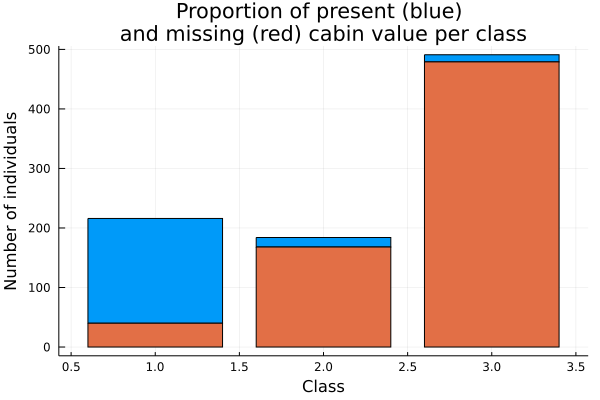

In [71]:
groupedbar(m, bar_position = :stack, 
    title="Proportion of present (blue) \nand missing (red) cabin value per class", 
    xlabel="Class", ylabel="Number of individuals", legend=false)

### It seems that our guess is correct.
Because there is a high correlation between the pressence of a cabin and the class of person, we can choose to discard the "Cabin" property.

In [73]:
select!(data, Not(:Cabin));

,PassengerId,Survived,Pclass,Name
,Int64,Int64,Int64,String
1,1,0,3,"Braund, Mr. Owen Harris"
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)"
3,3,1,3,"Heikkinen, Miss. Laina"
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
5,5,0,3,"Allen, Mr. William Henry"
6,6,0,3,"Moran, Mr. James"
7,7,0,1,"McCarthy, Mr. Timothy J"
8,8,0,3,"Palsson, Master. Gosta Leonard"
9,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"


### Let's now study the "Embarked" field

In [72]:
nmissing_embarked = 0

for value in eachrow(data)
    if ismissing(value.Embarked)
        nmissing_embarked += 1
    end
end

print(nmissing_embarked)

2

### There are only two values that are missing.
That is great news, it means that we could replace them with the most common port of embarkation without affecting the data distribution *too much*

### In the next steps, we will study the influence of each field on the "Survived" label.
First off, we can discard the PassengerId because it doesn't gives us any insight into anything.

In [74]:
select!(data, Not(:PassengerId));

### Pclass

In [76]:
all_classes = data[:, 3]
classes = unique(all_classes)

first_class = filter(x -> x.Pclass == 1, data)
first_class_survivors = filter(x -> x.Survived == 1, first_class)

second_class = filter(x -> x.Pclass == 2, data)
second_class_survivors = filter(x -> x.Survived == 1, second_class)

third_class = filter(x -> x.Pclass == 3, data)
third_class_survivors = filter(x -> x.Survived == 1, third_class);

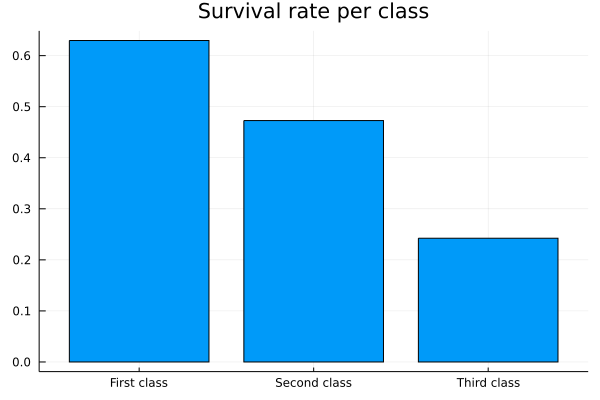

In [77]:
a1 = [nrow(first_class_survivors) / nrow(first_class),
        nrow(second_class_survivors) / nrow(second_class),
        nrow(third_class_survivors) / nrow(third_class)]

bar(["First class", "Second class", "Third class"], a1,
        title="Survival rate per class", legend=false)

In [81]:
cor(data.Survived, data.Pclass)

-0.33848103596101586

Great news, we found our first influencial value. Just by being in the first class, a person has a 60% chance of survival. We can hopefully combine this property with others to more accurately estimate our chances of survival. 

In [43]:
@doc Integer8

No documentation found.

Binding `Integer8` does not exist.


In [6]:
y = data.Survived

891-element Vector{Int64}:
 0
 1
 1
 1
 0
 0
 0
 0
 1
 1
 1
 1
 0
 ⋮
 1
 1
 0
 0
 0
 0
 0
 0
 1
 0
 1
 0